In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

import random
seed = 666
random.seed(seed)

from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import torch
from torch import optim
import torch.utils.data as utils
from torchvision import datasets
torch.manual_seed(seed)

from inv_vae.utils.helpers import Namespace, reset_weights, min_max_standardize, preprocess_neural_data
from inv_vae.models.vae import VAE
from inv_vae.models.inv_vae import INV_VAE

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

load and check sample data 

In [3]:
n_rois = 68
count_offset = 100
data_path = 'sample_data/hcp_data.npy'
brain_networks, traits, translations, rotations, avg_trans, avg_rotat = preprocess_neural_data(data_path)
n_subs = brain_networks.shape[0]
print(brain_networks.shape)
print(traits.shape)
print(translations.shape)
print(avg_trans.shape)

(1065, 4624)
(1065, 175)
(1065, 17)
(1065, 1)


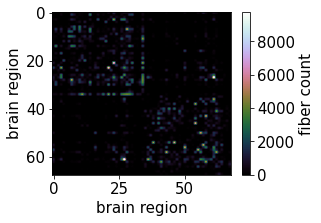

In [4]:
# check brain adjacency matrix

plt.figure(figsize=(4, 3))
plt.imshow(brain_networks.mean(0).reshape(n_rois, n_rois)*count_offset, aspect='auto', cmap='cubehelix')
plt.xlabel('brain region')
plt.ylabel('brain region')
plt.colorbar(label='fiber count')
plt.show()

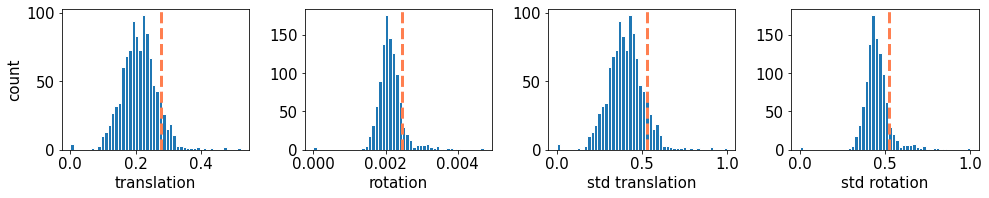

In [5]:
# check motion and rescale motion
std_trans = min_max_standardize(avg_trans)
std_rotat = min_max_standardize(avg_rotat)
motion = np.concatenate([std_trans, std_rotat], axis=-1)

fig, axes = plt.subplots(1,4,figsize=(14,3))
axes[0].hist(avg_trans, 50, edgecolor='white')
axes[0].axvline(x=np.quantile(avg_trans, .9), color='coral', ls='dashed', lw=3)
axes[0].set_xlabel('translation')
axes[0].set_ylabel('count')
axes[1].hist(avg_rotat, 50, edgecolor='white')
axes[1].axvline(x=np.quantile(avg_rotat, .9), color='coral', ls='dashed', lw=3)
axes[1].set_xlabel('rotation')
axes[2].hist(std_trans, 50, edgecolor='white')
axes[2].axvline(x=np.quantile(std_trans, .9), color='coral', ls='dashed', lw=3)
axes[2].set_xlabel('std translation')
axes[3].hist(std_rotat, 50, edgecolor='white')
axes[3].axvline(x=np.quantile(std_rotat, .9), color='coral', ls='dashed', lw=3)
axes[3].set_xlabel('std rotation')
plt.tight_layout()
plt.show()

In [6]:
# mark subjects with big motion for later analysis

sub_ids = np.arange(len(brain_networks)).reshape(-1,1)
big_trans_ids = sub_ids[std_trans > np.quantile(std_trans, .9)]
big_rotat_ids = sub_ids[std_rotat > np.quantile(std_rotat, .9)]
big_motion_ids = np.union1d(big_trans_ids, big_rotat_ids)
big_motion_mask = np.zeros_like(sub_ids)
big_motion_mask[np.isin(sub_ids, big_motion_ids)] = True
print('num of big motion subjects: {}.'.format(len(big_motion_ids)))

small_trans_ids = sub_ids[std_trans < np.quantile(std_trans, .1)]
small_rotat_ids = sub_ids[std_rotat < np.quantile(std_rotat, .1)]
small_motion_ids = np.union1d(small_trans_ids, small_rotat_ids)
small_motion_mask = np.zeros_like(sub_ids)
small_motion_mask[np.isin(sub_ids, small_motion_ids)] = True
print('num of small motion subjects: {}.'.format(len(small_motion_ids)))

num of big motion subjects: 166.
num of small motion subjects: 183.


model fitting

In [79]:
# model config

config = Namespace(n_nodes=n_rois, latent_dim=68, hidden_dim=1024, nuisance_dim=0,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0.,
    beta = .2, add_reg = True, y_dim = 1, 
    batch_size=32, n_epochs=200, lr=2e-6, device=DEVICE)

In [80]:
# prepare torch datasets for training

ids = list(range(n_subs))
random.shuffle(ids)
train_ids = ids[:int(.9*n_subs)]
val_ids = ids[int(.9*n_subs):]
print(len(train_ids), len(val_ids))

tensor_nets = torch.stack([torch.Tensor(i) for i in list(brain_networks)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_motion = torch.from_numpy(motion).to(torch.float32)
tensor_traits = torch.from_numpy(traits[:,4]).to(torch.float32) # oral reading recognition score

train_set = utils.TensorDataset(tensor_nets[train_ids], tensor_motion[train_ids], tensor_traits[train_ids] )
val_set = utils.TensorDataset(tensor_nets[val_ids], tensor_motion[val_ids],  tensor_traits[val_ids])

train_loader = utils.DataLoader(train_set, config.batch_size) 
val_loader = utils.DataLoader(val_set, config.batch_size)

958 107


In [81]:
# create masks for graph convolution layers

A_mat = np.mean(brain_networks.reshape(-1,n_rois,n_rois), axis=0)
A_mat = A_mat + A_mat.transpose()
knn_masks = [torch.from_numpy(np.float32(np.argsort(np.argsort(A_mat, axis=-1), axis=-1) < config.n_neighbors+i)).float() for i in range(config.n_dec_layers)]
print(len(knn_masks), knn_masks[0].shape)

5 torch.Size([68, 68])


vae

In [82]:
model = VAE(config).to(config.device)
model.apply(reset_weights)
model.set_mask(knn_masks)
optimizer = optim.Adam(model.parameters(), lr=config.lr) 

In [83]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = model.reg_train(epoch, train_loader, model, optimizer, config.device, n_epoch_display=5)
    val_loss = model.reg_test(epoch, val_loader, model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 15556.129 nll: 3908.457 kl: 347.968 rmse: 19.034
epoch: 0 test loss: 13941.612 nll: 2521.710 kl: 355.729 rmse: 20.200
epoch: 5 train loss: 2127.691 nll: -6363.185 kl: 847.303 rmse: 16.135
epoch: 5 test loss: 799.570 nll: -7390.481 kl: 1024.265 rmse: 16.942
epoch: 10 train loss: -6885.531 nll: -12510.477 kl: 2926.219 rmse: 12.554
epoch: 10 test loss: -7924.529 nll: -13308.624 kl: 3345.541 rmse: 13.015
epoch: 15 train loss: -11526.148 nll: -15504.032 kl: 6109.681 rmse: 9.280
epoch: 15 test loss: -12251.974 nll: -16115.999 kl: 6668.437 rmse: 9.529
epoch: 20 train loss: -13144.545 nll: -16511.916 kl: 8735.727 rmse: 7.112
epoch: 20 test loss: -13689.342 nll: -17032.111 kl: 9238.330 rmse: 7.318
epoch: 25 train loss: -13543.564 nll: -16740.786 kl: 9955.106 rmse: 6.135
epoch: 25 test loss: -14035.054 nll: -17237.356 kl: 10371.133 rmse: 6.352
epoch: 30 train loss: -13659.448 nll: -16793.008 kl: 10334.623 rmse: 5.768
epoch: 30 test loss: -14139.774 nll: -17286.885 kl: 10712.

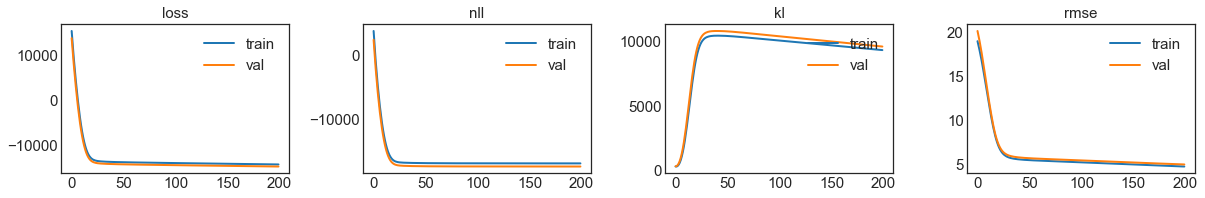

In [84]:
# diagnostics
fig, axes = plt.subplots(1, 4, figsize=(17, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)

axes[3].plot(train_losses[:,3], linewidth=2, label='train')
axes[3].plot(val_losses[:,3], linewidth=2, label='val')
axes[3].set_title('rmse')
axes[3].legend(loc=1)
plt.tight_layout()
plt.show()

In [85]:
# torch.save(model.state_dict(), './pretrained/hcp_vae_pretrained.mod')
# model.load_state_dict(torch.load('./pretrained/hcp_vae_pretrained.mod'))

In [86]:
z_mean, z_logvar = model.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
z_sample = model.reparameterize(z_mean, z_logvar)
vae_latents = z_sample.detach().cpu().numpy()
x_recon = model.decode(z_sample).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)

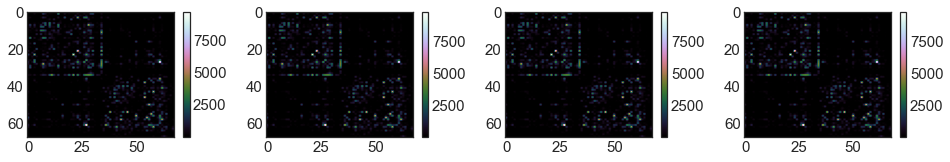

In [87]:
fig, axes = plt.subplots(1, 4, figsize=(13.5, 2.5))
for i, x in enumerate(x_recon[np.random.choice(ids, 4, replace=False)]):
    p = axes[i].imshow(x*count_offset, aspect='auto', cmap='cubehelix')
    cbar = plt.colorbar(p, ax=axes[i])
plt.tight_layout()
plt.show()  

In [88]:
big_motion_nets = brain_networks[big_motion_ids]
small_motion_nets = brain_networks[small_motion_ids]
diff_motion_nets = big_motion_nets.mean(0) - small_motion_nets.mean(0)

big_motion_recon = x_recon[big_motion_ids]
small_motion_recon = x_recon[small_motion_ids]
diff_motion_recon= big_motion_recon.mean(0) - small_motion_recon.mean(0)

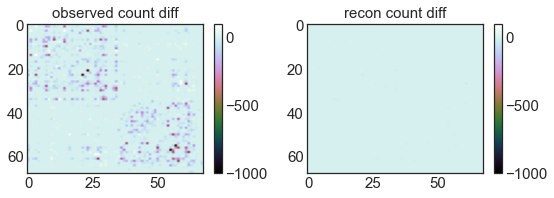

In [89]:
fig, axes = plt.subplots(1,2,figsize=(8,3))

p1=axes[0].imshow(diff_motion_nets.reshape(n_rois,n_rois)*count_offset, aspect='auto', cmap='cubehelix', vmin=-1000, vmax=100)
p2=axes[1].imshow(diff_motion_recon.reshape(n_rois,n_rois)*count_offset, aspect='auto', cmap='cubehelix', vmin=-1000, vmax=100)
axes[0].set_title('observed count diff')
axes[1].set_title('recon count diff')
cbar=plt.colorbar(p1, ax=axes[0])
cbar=plt.colorbar(p2, ax=axes[1])
plt.tight_layout()
plt.show()

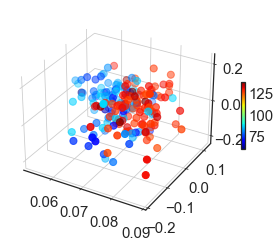

In [90]:
# viz of trait prediction

x_recon, y_pred, _, _ = model(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
y_pred = y_pred.detach().cpu().numpy()
y_obs = traits[:,4]

y_ids = np.argsort(y_obs)
y_sub_ids = np.concatenate([y_ids[:100], y_ids[-100:]])
labels = np.concatenate([np.zeros(100), np.ones(100)])
colors = y_obs[y_sub_ids]

z_mean_sub = z_mean[y_sub_ids, :].detach().cpu().numpy()
pca = PCA(n_components=3)
pca.fit(z_mean_sub.transpose())
pca_results = pca.components_.transpose()

plt.style.use('seaborn-white')
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(pca_results[:,0], pca_results[:,1], pca_results[:,2], c=colors, cmap = 'jet', s = 50)
cb = fig.colorbar(p, ax=ax, fraction=0.01)
ax.set_xlim3d(min(pca_results[:,0]), max(pca_results[:,0]))
ax.set_ylim3d(min(pca_results[:,1]), max(pca_results[:,1]))
ax.set_zlim3d(min(pca_results[:,2]), max(pca_results[:,2]))
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

inv-vae

In [69]:
# model config

config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=1024, nuisance_dim=2,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0.,
    beta = .2, gamma = 1., add_reg = True, y_dim = 1, 
    batch_size=32, n_epochs=200, lr=2e-6, device=DEVICE)

In [70]:
inv_model = INV_VAE(config).to(config.device)
inv_model.apply(reset_weights)
inv_model.set_mask(knn_masks)
optimizer = optim.Adam(inv_model.parameters(), lr=config.lr) 

In [71]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = inv_model.reg_train(epoch, train_loader, inv_model, optimizer, config.device, n_epoch_display=5)
    val_loss = inv_model.reg_test(epoch, val_loader, inv_model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 16088.694 nll: 4690.312 kl: 174.622 inv_loss: 2.742 rmse: 18.884
epoch: 0 test loss 14544.516 nll: 3111.852 kl: 185.426 inv_loss: 3.361 rmse: 20.299
epoch: 5 train loss: 1405.525 nll: -6923.007 kl: 906.567 inv_loss: 4.783 rmse: 16.137
epoch: 5 test loss 342.063 nll: -7904.048 kl: 1113.288 inv_loss: 7.078 rmse: 17.237
epoch: 10 train loss: -8393.275 nll: -13416.128 kl: 3279.741 inv_loss: 5.722 rmse: 12.524
epoch: 10 test loss -9108.530 nll: -13994.964 kl: 3660.222 inv_loss: 8.034 rmse: 13.267
epoch: 15 train loss: -13596.464 nll: -16050.896 kl: 7097.775 inv_loss: 4.233 rmse: 8.745
epoch: 15 test loss -14012.534 nll: -16353.595 kl: 7713.269 inv_loss: 5.391 rmse: 9.187
epoch: 20 train loss: -15694.567 nll: -16678.830 kl: 12262.371 inv_loss: 3.115 rmse: 5.524
epoch: 20 test loss -15964.492 nll: -16888.167 kl: 13015.521 inv_loss: 3.723 rmse: 5.778
epoch: 25 train loss: -16361.188 nll: -16796.653 kl: 16891.066 inv_loss: 2.438 rmse: 3.662
epoch: 25 test loss -16582.024 nl

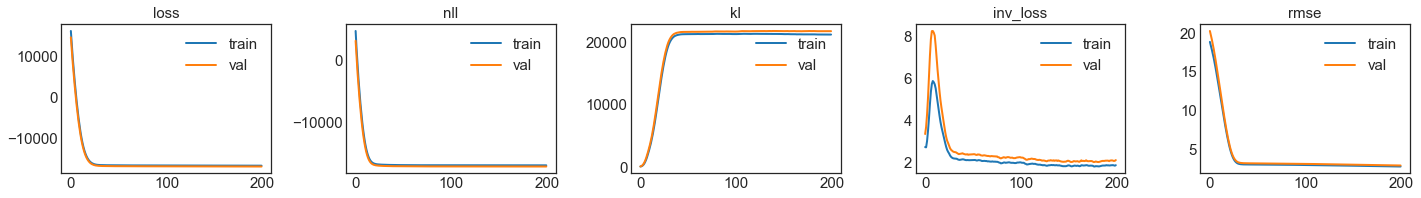

In [72]:
# diagnostics
fig, axes = plt.subplots(1, 5, figsize=(20, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)

axes[3].plot(train_losses[:,3], linewidth=2, label='train')
axes[3].plot(val_losses[:,3], linewidth=2, label='val')
axes[3].set_title('inv_loss')
axes[3].legend(loc=1)

axes[4].plot(train_losses[:,4], linewidth=2, label='train')
axes[4].plot(val_losses[:,4], linewidth=2, label='val')
axes[4].set_title('rmse')
axes[4].legend(loc=1)

plt.tight_layout()
plt.show()

In [73]:
# torch.save(inv_model.state_dict(), './pretrained/abcd_inv_vae_pretrained.mod')
# inv_model.load_state_dict(torch.load('./pretrained/abcd_inv_vae_pretrained.mod'))

In [74]:
z_mean, z_logvar = inv_model.encode(tensor_nets.to(config.device))
z_sample = inv_model.reparameterize(z_mean, z_logvar)
inv_latents = z_sample.detach().cpu().numpy()

x_denoised = inv_model.decode(z_sample, 
                      torch.zeros_like(tensor_motion).to(config.device) 
                      ).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)

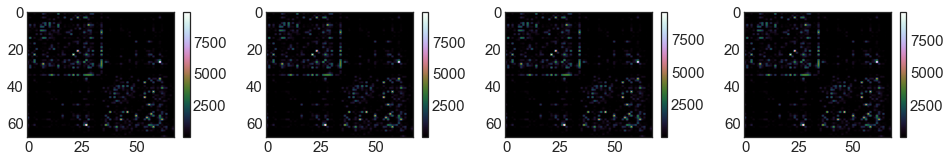

In [75]:
fig, axes = plt.subplots(1, 4, figsize=(13.5, 2.5))
for i, x in enumerate(x_denoised[np.random.choice(ids, 4, replace=False)]):
    p = axes[i].imshow(x*count_offset, aspect='auto', cmap='cubehelix')
    cbar = plt.colorbar(p, ax=axes[i])
plt.tight_layout()
plt.show()  

In [76]:
big_motion_nets = brain_networks[big_motion_ids]
small_motion_nets = brain_networks[small_motion_ids]
diff_motion_nets = big_motion_nets.mean(0) - small_motion_nets.mean(0)

big_motion_denoised = x_denoised[big_motion_ids]
small_motion_denoised = x_denoised[small_motion_ids]
diff_motion_denoised = big_motion_denoised.mean(0) - small_motion_denoised.mean(0)

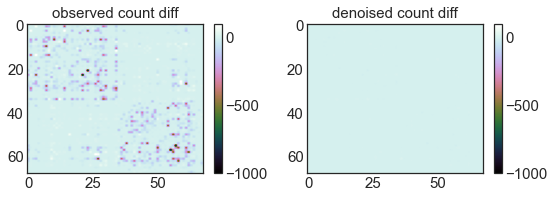

In [77]:
fig, axes = plt.subplots(1,2,figsize=(8,3))

p1=axes[0].imshow(diff_motion_nets.reshape(n_rois,n_rois)*count_offset, aspect='auto', cmap='cubehelix', vmin=-1000, vmax=100)
p2=axes[1].imshow(diff_motion_denoised.reshape(n_rois,n_rois)*count_offset, aspect='auto', cmap='cubehelix', vmin=-1000, vmax=100)
axes[0].set_title('observed count diff')
axes[1].set_title('denoised count diff')
cbar=plt.colorbar(p1, ax=axes[0])
cbar=plt.colorbar(p2, ax=axes[1])
plt.tight_layout()
plt.show()

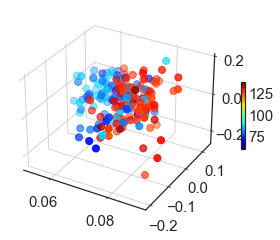

In [78]:
# viz of trait prediction

x_recon, y_pred, _, _ = inv_model(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device),
                            tensor_motion.to(config.device))
y_pred = y_pred.detach().cpu().numpy()
y_obs = traits[:,4]

y_ids = np.argsort(y_obs)
y_sub_ids = np.concatenate([y_ids[:100], y_ids[-100:]])
labels = np.concatenate([np.zeros(100), np.ones(100)])
colors = y_obs[y_sub_ids]

z_mean_sub = z_mean[y_sub_ids, :].detach().cpu().numpy()
pca = PCA(n_components=3)
pca.fit(z_mean_sub.transpose())
pca_results = pca.components_.transpose()

plt.style.use('seaborn-white')
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(pca_results[:,0], pca_results[:,1], pca_results[:,2], c=colors, cmap = 'jet', s = 50)
cb = fig.colorbar(p, ax=ax, fraction=0.01)
ax.set_xlim3d(min(pca_results[:,0]), max(pca_results[:,0]))
ax.set_ylim3d(min(pca_results[:,1]), max(pca_results[:,1]))
ax.set_zlim3d(min(pca_results[:,2]), max(pca_results[:,2]))
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))